<a href="https://colab.research.google.com/github/Bhuvaneswarij/gitingest/blob/main/TIme_series_(LSTM)pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
try:
    import shap
    import optuna
    import pmdarima as pmd
    from prophet import Prophet
except:
    !pip install shap optuna pmdarima prophet --quiet
    import shap
    import optuna
    import pmdarima as pmd
    from prophet import Prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 22.7 MB/s eta 0:00:00


In [4]:
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2024-12-01"

In [5]:
print(f"Downloading data for {TICKER}...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)
df = df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [6]:
df["return"] = df["Close"].pct_change()
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df["MA7"] = df["Close"].rolling(7).mean()
df["MA21"] = df["Close"].rolling(21).mean()
df["Volatility"] = df["Close"].rolling(21).std()

In [7]:
delta = df["Close"].diff()
gain = delta.clip(lower=0)
loss = -1 * delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

In [8]:
df = df.dropna()

In [9]:
SEQ_LEN = 60
TEST_RATIO = 0.2

In [10]:
features = ["Open","High","Low","Close","Volume","MA7","MA21","Volatility","RSI","return","log_return"]
target = "Close"
X = df[features].values
y = df[target].values

In [11]:
n_test = int(len(X)*TEST_RATIO)
X_trainval, X_test = X[:-n_test], X[-n_test:]
y_trainval, y_test = y[:-n_test], y[-n_test:]

In [12]:
n_val = int(len(X_trainval)*0.1)
X_train, X_val = X_trainval[:-n_val], X_trainval[-n_val:]
y_train, y_val = y_trainval[:-n_val], y_trainval[-n_val:]


In [13]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_val_s = scaler_X.transform(X_val)
X_test_s = scaler_X.transform(X_test)

In [14]:
y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_val_s = scaler_y.transform(y_val.reshape(-1,1)).flatten()
y_test_s = scaler_y.transform(y_test.reshape(-1,1)).flatten()


In [15]:
def create_sequences(X, y, seq_len=SEQ_LEN):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

In [16]:

X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_s)
X_val_seq, y_val_seq = create_sequences(X_val_s, y_val_s)
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test_s)

In [17]:
def build_lstm(seq_len, n_features, units=64, dropout=0.2, l1=0.0, l2=0.0, lr=1e-3):
    from tensorflow.keras.regularizers import l1_l2
    reg = l1_l2(l1=l1,l2=l2) if (l1>0 or l2>0) else None
    model = Sequential()
    model.add(LSTM(units, input_shape=(seq_len, n_features), kernel_regularizer=reg))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

In [18]:
n_features = X_train_seq.shape[2]
model = build_lstm(SEQ_LEN, n_features, units=64, dropout=0.2)

In [19]:
ckpt = ModelCheckpoint("point_lstm.h5", save_best_only=True, monitor='val_loss')
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

In [20]:
history = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                    epochs=50, batch_size=64, callbacks=[ckpt, es], verbose=1)


Epoch 1/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.7225

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.7032 - val_loss: 4.9080
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0339

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0338 - val_loss: 2.5414
Epoch 3/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0207

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0206 - val_loss: 1.9259
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0174

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0174 - val_loss: 1.7419
Epoch 5/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0137

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0138 - val_loss: 1.6400
Epoch 6/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0152

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0151 - val_loss: 1.4177
Epoch 7/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0117

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0117 - val_loss: 1.2260
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0126 - val_loss: 1.5131
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0122 - val_loss: 1.3338
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0099 - val_loss: 1.4947
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0095 - val_loss: 1.4128
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0098 - val_loss: 1.2379
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0093

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0093 - val_loss: 1.2083
Epoch 14/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0092

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0092 - val_loss: 1.0677
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0089 - val_loss: 1.0861
Epoch 16/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0079 - val_loss: 1.1067
Epoch 17/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0107 - val_loss: 1.5159
Epoch 18/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0079

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0079 - val_loss: 0.7013
Epoch 19/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0121 - val_loss: 1.0698
Epoch 20/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0119

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0118 - val_loss: 0.6999
Epoch 21/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0093 - val_loss: 0.8169
Epoch 22/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0068 - val_loss: 1.0197
Epoch 23/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0067

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0068 - val_loss: 0.5615
Epoch 24/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0073 - val_loss: 0.7404
Epoch 25/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0089 - val_loss: 0.8343
Epoch 26/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0075 - val_loss: 0.7561
Epoch 27/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0076 - val_loss: 1.2216
Epoch 28/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0100 - val_loss: 0.7344
Epoch 29/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0080

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0080 - val_loss: 0.4959
Epoch 30/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0095 - val_loss: 0.6867
Epoch 31/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0076 - val_loss: 0.7980
Epoch 32/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0071 - val_loss: 0.7211
Epoch 33/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0066 - val_loss: 0.6865
Epoch 34/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0079 - val_loss: 0.6545
Epoch 35/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0061

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0061 - val_loss: 0.4585
Epoch 36/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0078 - val_loss: 0.5342
Epoch 37/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0075 - val_loss: 0.5411
Epoch 38/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0072 - val_loss: 0.5854
Epoch 39/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0076 - val_loss: 0.7980
Epoch 40/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0065 - val_loss: 0.7711
Epoch 41/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0067 - val_loss: 0.6622
Epoch 42/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0064 - val_loss: 0.8770
Epoch 43/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0062

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0062 - val_loss: 0.3646
Epoch 44/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0145 - val_loss: 1.1348
Epoch 45/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0090 - val_loss: 0.7862
Epoch 46/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0060 - val_loss: 0.9023
Epoch 47/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0076 - val_loss: 0.8945
Epoch 48/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0056 - val_loss: 0.9114
Epoch 49/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0066 - val_loss: 0.5420
Epoch 50/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0071 - val_loss: 0.6844


In [21]:
model.load_weights("point_lstm.h5")
y_pred_s = model.predict(X_test_seq).flatten()
y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
y_true = y_test[SEQ_LEN:]

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [22]:

print("Test MAE:", mean_absolute_error(y_true, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))

Test MAE: 36.65827240123693
Test RMSE: 43.2662549087961


In [23]:
def build_mc_lstm(seq_len, n_features, units=64, dropout=0.2, lr=1e-3):
    inp = Input(shape=(seq_len, n_features))
    x = LSTM(units)(inp)
    d = Dropout(dropout)
    x = d(x, training=True)
    out = Dense(1)(x)
    model = Model(inp,out)
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

In [24]:
mc_model = build_mc_lstm(SEQ_LEN, n_features, units=64, dropout=0.2)
es_mc = EarlyStopping(patience=10, restore_best_weights=True)
mc_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=50, batch_size=64, callbacks=[es_mc], verbose=1)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.3148 - val_loss: 3.1994
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0234 - val_loss: 1.7957
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0184 - val_loss: 1.9431
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0165 - val_loss: 1.8093
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0144 - val_loss: 1.5667
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0132 - val_loss: 1.5273
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0098 - val_loss: 1.2403
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0130 - val_loss: 1.3106
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0125 - val_loss: 1.2135
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0120 - val_loss: 1.3070
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0124 - val_loss: 1.0182
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0

In [25]:
N_MONTECARLO = 500
ALPHA = 0.05
preds = []
for _ in range(N_MONTECARLO):
    p = mc_model.predict(X_test_seq, verbose=0).flatten()
    preds.append(p)
preds = np.vstack(preds)
median = np.median(preds, axis=0)
lower = np.percentile(preds, 100*ALPHA/2, axis=0)
upper = np.percentile(preds, 100*(1-ALPHA/2), axis=0)

In [26]:
median = scaler_y.inverse_transform(median.reshape(-1,1)).flatten()
lower = scaler_y.inverse_transform(lower.reshape(-1,1)).flatten()
upper = scaler_y.inverse_transform(upper.reshape(-1,1)).flatten()

In [27]:
covered = ((y_true >= lower) & (y_true <= upper)).astype(int)
ICP_mc = covered.mean()
MIW_mc = np.mean(upper - lower)
print("MC Dropout Interval metrics → ICP:", ICP_mc, "MIW:", MIW_mc)

MC Dropout Interval metrics → ICP: 0.0 MIW: 0.0


In [28]:
def pinball_loss(q):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(q*e, (q-1)*e))
    return loss

In [29]:
qs = [0.1, 0.5, 0.9]
q_preds = {}
for q in qs:
    model_q = Sequential([LSTM(64, input_shape=(SEQ_LEN, n_features)), Dropout(0.2), Dense(1)])
    model_q.compile(optimizer=Adam(1e-3), loss=pinball_loss(q))
    es = EarlyStopping(patience=8, restore_best_weights=True)
    model_q.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=50, batch_size=64, callbacks=[es], verbose=0)
    pred_s = model_q.predict(X_test_seq).flatten()
    pred = scaler_y.inverse_transform(pred_s.reshape(-1,1)).flatten()
    q_preds[q] = pred


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [30]:
q_lower = q_preds[0.1]
q_upper = q_preds[0.9]
covered_q = ((y_true >= q_lower) & (y_true <= q_upper)).astype(int)
ICP_q = covered_q.mean()
MIW_q = np.mean(q_upper - q_lower)
print("Quantile LSTM metrics → ICP:", ICP_q, "MIW:", MIW_q)

Quantile LSTM metrics → ICP: 0.2554717847155522 MIW: 26.535652


In [31]:
try:
    sarima_model = pmd.auto_arima(y_train, seasonal=False, stepwise=True, suppress_warnings=True)
    fc, conf_int = sarima_model.predict(n_periods=len(y_test), return_conf_int=True)
    sarima_lower = conf_int[:,0]
    sarima_upper = conf_int[:,1]
    covered_s = ((y_true >= sarima_lower) & (y_true <= sarima_upper)).astype(int)
    ICP_s = covered_s.mean()
    MIW_s = np.mean(sarima_upper - sarima_lower)
    print("SARIMA → ICP:", ICP_s, "MIW:", MIW_s)
except Exception as e:
    print("SARIMA failed:", e)

SARIMA → ICP: 0.942249822180883 MIW: 4287.473948527214


In [32]:
try:
    pf_df = df[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
    m = Prophet(daily_seasonality=False, yearly_seasonality=True)
    m.fit(pf_df[:-len(y_test)])
    future = m.make_future_dataframe(periods=len(y_test))
    fcst = m.predict(future)
    pf_mean = fcst['yhat'].values[-len(y_test):]
    pf_lower = fcst['yhat_lower'].values[-len(y_test):]
    pf_upper = fcst['yhat_upper'].values[-len(y_test):]
    covered_p = ((y_true >= pf_lower) & (y_true <= pf_upper)).astype(int)
    ICP_p = covered_p.mean()
    MIW_p = np.mean(pf_upper - pf_lower)
    print("Prophet → ICP:", ICP_p, "MIW:", MIW_p)
except Exception as e:
    print("Prophet failed:", e)


Prophet failed: arg must be a list, tuple, 1-d array, or Series


In [33]:
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_test_flat = X_test_seq.reshape(X_test_seq.shape[0], -1)

In [34]:
def model_predict(x):
    x_seq = x.reshape(x.shape[0], SEQ_LEN, n_features)
    return model.predict(x_seq).flatten()


In [35]:
explainer = shap.KernelExplainer(model_predict, X_train_flat[:100])
shap_values = explainer.shap_values(X_test_flat[:50])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 114s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 123s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 134s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 113s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 112s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 111s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 112s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
10525/10525 ━━━━━━━━━━━━━━━━━━━━ 112s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
10525/10525 ━━━

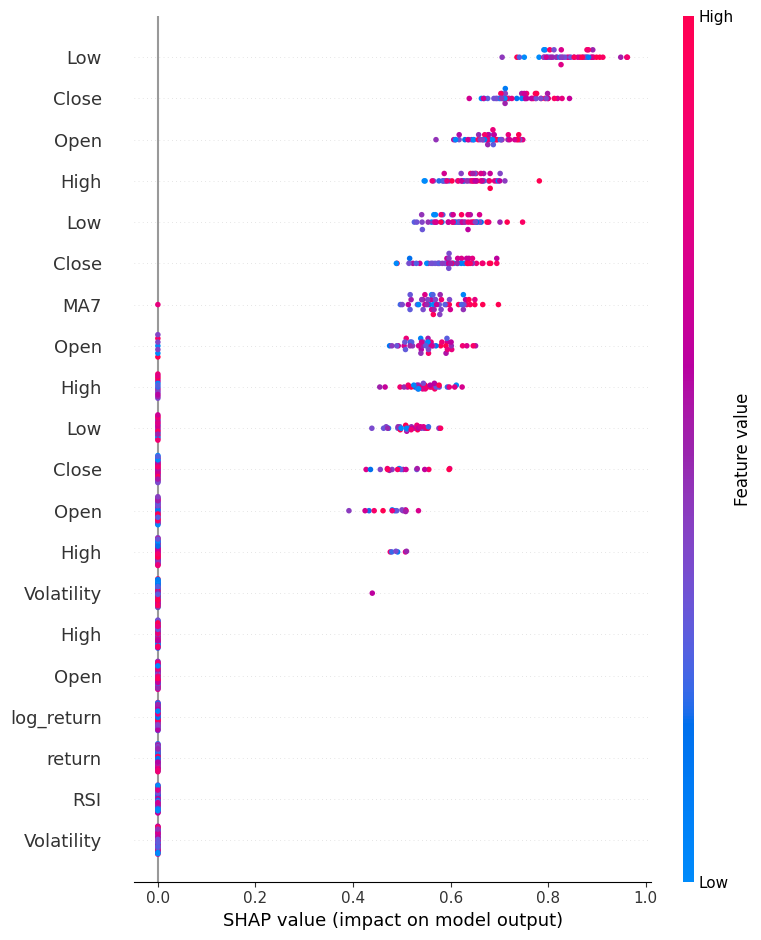

In [36]:
shap.summary_plot(shap_values, X_test_flat[:50], feature_names=np.tile(features, SEQ_LEN))


In [40]:
# ---- Ensure all arrays are 1D ----
y_true = np.array(y_true).squeeze()
y_pred = np.array(y_pred).squeeze()
lower = np.array(lower).squeeze()
upper = np.array(upper).squeeze()

print("Shapes:")
print("y_true :", y_true.shape)
print("y_pred :", y_pred.shape)
print("lower  :", lower.shape)
print("upper  :", upper.shape)

# ---- Create Results DataFrame ----
results = pd.DataFrame({
    "y_true": y_true,
    "point_pred": y_pred,
    "mc_lower": lower,
    "mc_upper": upper,
})

results.head()


Shapes:
y_true : (686,)
y_pred : (686,)
lower  : (686,)
upper  : (686,)


,y_true,point_pred,mc_lower,mc_upper
0,155.460754,136.603882,133.604141,133.604141
1,151.743881,133.803055,132.935867,132.935867
2,147.713242,132.338364,131.698425,131.698425
3,152.096970,131.025742,130.791550,130.791550
4,156.510117,134.723877,132.468307,132.468307


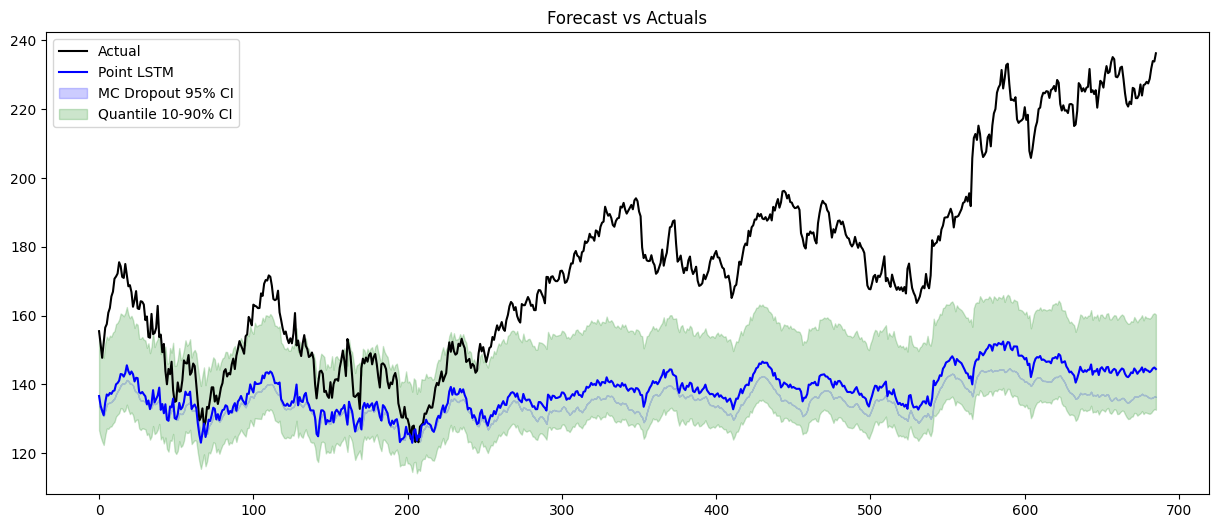

In [42]:
plt.figure(figsize=(15,6))
plt.plot(y_true, label='Actual', color='black')
plt.plot(y_pred, label='Point LSTM', color='blue')
plt.fill_between(range(len(y_true)), lower, upper, color='blue', alpha=0.2, label='MC Dropout 95% CI')
plt.fill_between(range(len(y_true)), q_lower, q_upper, color='green', alpha=0.2, label='Quantile 10-90% CI')
plt.title("Forecast vs Actuals")
plt.legend()
plt.show()